In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta

import cufflinks as cf
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
df_main = pd.read_csv('snow3300.csv')
pd.set_option('max_columns', None)

In [3]:
# TO INCLUDE ONLY RESULTS AFTER OCTOBER, USE THIS
df_main = df_main[ df_main['opened_at'] > '2020-10-01' ]

### Transform datatypes to datetime and adding additional time columns

In [4]:
# Change datatypes of all time-based columns
time_columns = ['sys_updated_on', 'sys_created_on', 'closed_at', 'opened_at', 'business_duration', 'reopened_time',
                'resolved_at', 'work_start', 'calendar_duration']

for item in time_columns:
    df_main[item] = pd.to_datetime(df_main[item])

# Create additional time columns
df_main['opened_at'] = df_main['opened_at'] - timedelta(hours=5)
df_main['resolved_at'] = df_main['resolved_at'] - timedelta(hours=5)
df_main['opened_at_hour'] = df_main['opened_at'].dt.hour
df_main['opened_at_month'] = df_main['opened_at'].dt.month
df_main['opened_at_day'] = df_main['opened_at'].dt.day
df_main['opened_at_day_of_year'] = df_main['opened_at'].dt.dayofyear
df_main['opened_at_clone'] = df_main['opened_at']
df_main['resolution_time_length'] = df_main.resolved_at - df_main.opened_at
df_main['resolution_time_total_hours'] = df_main['resolution_time_length'].dt.total_seconds()/3600
print(type(df_main['opened_at_clone'].iloc[0]))
df_main[['opened_at', 'task_effective_number', 'opened_at_hour', 'opened_at_month', 'opened_at_day', 'opened_at_day_of_year',
         'opened_at_clone', 'resolution_time_length', 'resolution_time_total_hours']].head(5).sort_values('opened_at_day').head(2)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,opened_at,task_effective_number,opened_at_hour,opened_at_month,opened_at_day,opened_at_day_of_year,opened_at_clone,resolution_time_length,resolution_time_total_hours
5,2020-11-02 11:02:50,INC0053368,11,11,2,307,2020-11-02 11:02:50,1 days 23:49:28,47.824444
4,2020-12-03 16:29:25,INC0056332,16,12,3,338,2020-12-03 16:29:25,0 days 01:06:38,1.110556


### How many INC per hour (assigned to included within our search parameters)

In [5]:
df_inc_per_hr = df_main['task_effective_number'].groupby(df_main['opened_at'].dt.hour).count()
df_inc_per_hr

opened_at
0       3
1       1
2       2
3       1
6       7
7      70
8     271
9     344
10    318
11    249
12    208
13    198
14    184
15    159
16    130
17     59
18     22
19     11
20     12
21      9
22      2
23      3
Name: task_effective_number, dtype: int64

In [6]:
fig = px.bar(df_inc_per_hr, x=df_inc_per_hr.index, y='task_effective_number', labels={'opened_at':'Hour Opened', 'task_effective_number':'Total Count of Incidents'})
fig.show()

### What is the timeframe of this data

In [7]:
# to pull days as int (for calculations)
# print((df_main['opened_at'].max() - df_main['opened_at'].min()).days)
print('earliest:   '+str(df_main['opened_at'].min()))
print('latest:     '+str(df_main['opened_at'].max()))
print('timespan:   '+str(df_main['opened_at'].max() - df_main['opened_at'].min()))

earliest:   2020-10-01 07:59:03
latest:     2021-03-09 15:27:40
timespan:   159 days 07:28:37


In [8]:
# Total number of incidents tracked within this selection
print('Total number of incidents tracked within this selection: ' + str(df_main['opened_at'].count()))

Total number of incidents tracked within this selection: 2263


### Name Transformations

In [9]:
# place all transformations here
df_main = df_main.replace(['2d5d343adb2d17009f9aec51ca9619e9'],['five9'])

### How quickly are INC resolved

In [10]:
# can we find how quickly tickets were picked up by doing this: work_start opened_at
df_resolution_time = df_main['resolution_time_length']
fig = px.histogram(df_resolution_time, x="resolution_time_length")#, histnorm='probability density')
fig.show()

In [11]:
# Histogram of INC resolved per hour
fig = px.histogram(df_main['resolution_time_total_hours'], x="resolution_time_total_hours", range_x=[0,200], nbins=300)
fig.show()

In [12]:
# breakdown of resolution time column
df_main['resolution_time_length'].describe()

count                         2245
mean     1 days 02:20:50.780846325
std      2 days 16:36:18.881479974
min                0 days 00:00:00
25%                0 days 00:37:29
50%                0 days 02:25:06
75%                0 days 23:22:56
max               55 days 23:44:46
Name: resolution_time_length, dtype: object

In [13]:
# how many INC took more than 5 days
df_lots_of_time = df_main[ df_main['resolution_time_length'] > '5 days 00:00:00' ]

# How many INC of greater than 5 days were there?
print(df_lots_of_time['resolution_time_length'].count())

# What is percent of tickets that took longer than 5 days
print(df_lots_of_time['resolution_time_length'].count() / df_main['opened_at'].count())

125
0.0552364118426867


In [14]:
# show number of tickets by INC-caller 
fig = px.bar(df_main['sys_created_by'].value_counts(), x=df_main['sys_created_by'].value_counts().index,
             y='sys_created_by', labels={'x':'Username', 'sys_created_by':'Number of INC opened'})
fig.update_xaxes(range=[0,50])
fig.show()

In [15]:
# df_test = df_main['sys_created_by'].value_counts()
# px.bar(df_test[:50])

In [16]:
# show percentage of tickets by INC-caller
percent = df_main['sys_created_by'].value_counts(normalize=True, ascending=False)

fig = px.bar(percent, x=percent.index,
             y='sys_created_by', labels={'index':'Username', 'sys_created_by':'Percent of total INC opened'})
fig.update_xaxes(range=[0,50])
fig.show()

In [17]:
# df_percent = df_main['sys_created_by'].value_counts(normalize=True, ascending=False)
# px.bar(df_percent[:10])

In [18]:
# place series values into bins for histogram
# only works on NUMERICAL columns
df_main['resolution_time_length'].value_counts(normalize=True, ascending=False, bins=1350).head(10)

(-1 days +22:39:22.513999999, 0 days 00:59:43.322962962]    0.334070
(0 days 00:59:43.322962962, 0 days 01:59:26.645925925]      0.129916
(0 days 01:59:26.645925925, 0 days 02:59:09.968888888]      0.066726
(0 days 02:59:09.968888888, 0 days 03:58:53.291851851]      0.043305
(0 days 03:58:53.291851851, 0 days 04:58:36.614814814]      0.030932
(0 days 04:58:36.614814814, 0 days 05:58:19.937777777]      0.014582
(0 days 19:54:26.459259259, 0 days 20:54:09.782222222]      0.014141
(0 days 05:58:19.937777777, 0 days 06:58:03.260740740]      0.013699
(1 days 00:53:03.074074074, 1 days 01:52:46.397037037]      0.012815
(0 days 22:53:36.428148148, 0 days 23:53:19.751111111]      0.012373
Name: resolution_time_length, dtype: float64

In [19]:
histo = df_main['resolution_time_length'].value_counts(normalize=True, ascending=False, bins=1350).head(10)
histo

(-1 days +22:39:22.513999999, 0 days 00:59:43.322962962]    0.334070
(0 days 00:59:43.322962962, 0 days 01:59:26.645925925]      0.129916
(0 days 01:59:26.645925925, 0 days 02:59:09.968888888]      0.066726
(0 days 02:59:09.968888888, 0 days 03:58:53.291851851]      0.043305
(0 days 03:58:53.291851851, 0 days 04:58:36.614814814]      0.030932
(0 days 04:58:36.614814814, 0 days 05:58:19.937777777]      0.014582
(0 days 19:54:26.459259259, 0 days 20:54:09.782222222]      0.014141
(0 days 05:58:19.937777777, 0 days 06:58:03.260740740]      0.013699
(1 days 00:53:03.074074074, 1 days 01:52:46.397037037]      0.012815
(0 days 22:53:36.428148148, 0 days 23:53:19.751111111]      0.012373
Name: resolution_time_length, dtype: float64

In [20]:
df_lots_of_time['category'].value_counts()

hardware         31
software         29
Telephony        22
System Access    10
Networking        4
Inquiry/Help      3
Security          1
inquiry           1
Name: category, dtype: int64

In [21]:
df_main['subcategory'].value_counts().head()

Soft Phone                           433
Laptop                               229
Password Reset                       135
Multi-Factor / RSA Authentication    102
Microsoft Outlook                     96
Name: subcategory, dtype: int64

In [22]:
df_lots_of_time['subcategory'].value_counts().head()

Soft Phone         22
Laptop             22
Windows             6
Microsoft Teams     5
Peripheral          4
Name: subcategory, dtype: int64

In [23]:
df_long_monitors = df_lots_of_time[ df_lots_of_time['subcategory'] == 'Peripheral']
df_long_monitors['task_effective_number']

2160    INC0063591
2611    INC0052926
2699    INC0051682
2915    INC0053800
Name: task_effective_number, dtype: object

In [24]:
# replace 'NaN' values with '0'
# not sure if this actually should be done. I think it did not reflect null values until changing to a 0
df_main['subcategory'] = df_main['subcategory'].fillna(0)
df_main['category'] = df_main['category'].fillna(0)

In [25]:
# what are incidents where subcategory is null?
df_no_subcategory = df_main[ df_main['subcategory'] == 0 ]
df_no_subcategory[['task_effective_number', 'resolved_by_username_value', 'short_description', 'subcategory']].head()

,task_effective_number,resolved_by_username_value,short_description,subcategory
2,INC0062835,Shawn McCoy,UI is spinning and not allowing a void to go t...,0
4,INC0056332,Shawn McCoy,Issue with scan to email from scanner in the B...,0
8,INC0062670,Shawn McCoy,Cisco Jabber is still connected to office phone,0
13,INC0053835,Shawn McCoy,5 9 is not calling,0
16,INC0060509,Shawn McCoy,"VPN connected (Cisco AnyConnect), my internet ...",0


In [26]:
# And how many INC are there with subcategory set to 'null'
print(df_main['task_effective_number'][ df_main['subcategory'] == 0 ].count())

666


In [27]:
# what percentage of tickets overall have subcategory set to null
(df_main['task_effective_number'][ df_main['subcategory'] == 0 ].count())/df_main['opened_at'].count()

0.29429960229783475

In [28]:
df_cat_but_no_subcat = df_no_subcategory[ df_no_subcategory['category'] != 0 ]
df_cat_but_no_subcat[['category', 'subcategory']]
df_cat_but_no_subcat['category'].value_counts()

software         100
System Access     75
Inquiry/Help      20
hardware          14
Networking         8
inquiry            6
Audio/Visual       5
Server             1
Telephony          1
VDI DaaS           1
Name: category, dtype: int64

In [29]:
df_main['subcategory'].value_counts().head(20)

0                                    666
Soft Phone                           433
Laptop                               229
Password Reset                       135
Multi-Factor / RSA Authentication    102
Microsoft Outlook                     96
VPN                                   86
Peripheral                            81
Windows                               69
Active Directory                      63
monitor                               38
Microsoft Teams                       31
Microsoft Excel                       29
Google Chrome                         18
Desktop                               17
General Question                      14
Wireless Connectivity                 13
Adobe Acrobat                         12
Email Signature Manager               12
Printer                               11
Name: subcategory, dtype: int64

In [30]:
# build word cloud for meta tag spotting
df_mfa = df_main[ df_main['subcategory'] == 'Multi-Factor / RSA Authentication' ]
df_mfa['task_effective_number'].count()

102

In [31]:
df_mfa[['task_effective_number', 'short_description', 'close_notes']].head(3)

,task_effective_number,short_description,close_notes
21,INC0051262,Cannot log into authenticator App on my new ph...,"reset users mfa, on next log in it will prompt..."
58,INC0054725,cant login in vpn,deleted xml from C:\Users\\AppData\Local\Cisco...
164,INC0054618,VPN unable to connect,deleted xml from C:\Users\x110405\AppData\Loca...


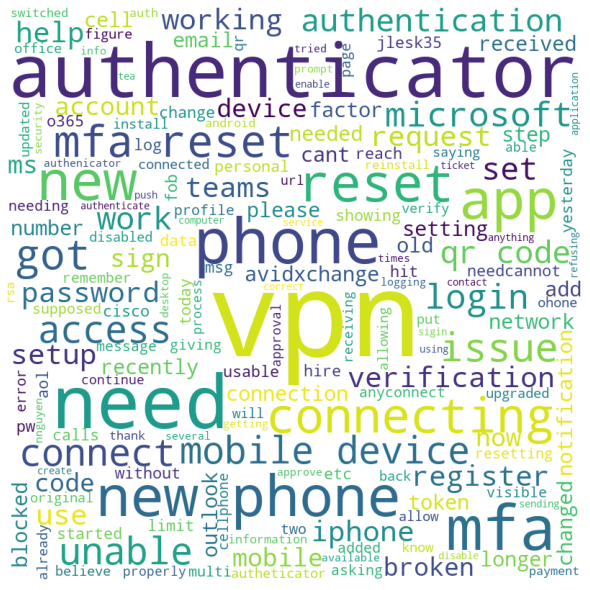

In [32]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

comment_words = 'need'
stopwords = set(STOPWORDS)
  
# iterate through the df
for val in df_mfa.short_description:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [33]:
# how many five9 tickets
df_five9 = df_main[ df_main['configuration_item_value'] == 'five9' ]
df_five9['task_effective_number'].count()

459

In [34]:
# want to have time-series line chart. x-axis: time since 1st recorded ticket, for all tickets y-axis: count of five9 tickets per day
# what is avg resolution time for five9 tickets
df_five9['resolution_time_length'].mean()

Timedelta('1 days 02:38:54.954048140')

In [35]:
# df_five9.groupby('subcategory').resolution_time_length.mean()
# print(type(df_five9['resolution_time_length']))

In [36]:
# who is resolving the tickets? (returns a userID)
unique_list = []

for x in df_main['resolved_by_username_value']:
    try:
        if x not in unique_list:
            unique_list.append(x)
    except:
        pass

# # list of unique user id's (for users that resolved tickets)
# for item in unique_list:
#     print(item)

In [37]:
# how many of these tickets are resolved by these individuals
count = df_main['resolved_by_username_value'].value_counts(normalize=True)
print(count)

Taylor Ramsey                       0.493987
Shawn McCoy                         0.299332
Valentin Correa                     0.125612
Tiffany Leonard                     0.020490
Jacob Webb                          0.006682
                                      ...   
56db5745db4510505cfba895ca961900    0.000445
d0efcfd0db5080909f9aec51ca96196e    0.000445
5158836adbe744d020acde82ca961940    0.000445
393c1a94db1c4780094bf209af9619b6    0.000445
2035a0d3dbd56600094bf209af961936    0.000445
Name: resolved_by_username_value, Length: 87, dtype: float64


In [38]:
df_main['opened_at'].groupby(df_main['resolved_by_username_value']).count().sort_values(ascending=False)

resolved_by_username_value
Taylor Ramsey                       1109
Shawn McCoy                          672
Valentin Correa                      282
Tiffany Leonard                       46
Jacob Webb                            15
                                    ... 
555678b6dba190905cfba895ca96193e       1
5158836adbe744d020acde82ca961940       1
4a97b10edbd3ab805cfba895ca9619d4       1
4a520c3bdb86a300bd3ec170ba961951       1
f262b9b5db17581047c62f75ca9619cb       1
Name: opened_at, Length: 87, dtype: int64

In [39]:
# THIS IS A BAD WAY TO DO THIS, earliest time here is: 2018-12-18 15:47:12
df_five9_by_day = df_five9['task_effective_number'].groupby(df_main['opened_at_day_of_year']).count()
fig = px.line(df_five9_by_day, x=df_five9_by_day.index, y="task_effective_number", title='Count of Five9 INC Per Day')
fig.show()

In [40]:
try:
    df_five9.set_index('opened_at_clone', inplace=True)
except:
    pass
df_five9.sort_values('opened_at_clone').head(3)

,u_repeat,made_sla,upon_reject,u_money_movement,sys_updated_on,child_incidents,task_effective_number,number,u_vcc,sys_updated_by,sys_created_on,u_dollar_impact,state,sys_created_by,knowledge,u_external_customer_impacted,u_ach,calendar_stc,closed_at,impact,active,priority,sys_domain_path,opened_at,business_duration,reopened_time,resolved_at,u_hub,u_avidpay_check,u_core,u_ipay,subcategory,u_avidpay_direct,short_description,work_start,close_code,u_pir_requested,u_check,business_stc,calendar_duration,notify,sys_class_name,close_notes,parent_incident,u_choice_6,sys_id,contact_type,reopened_by,incident_state,urgency,u_utility,reassignment_count,severity,approval,sys_mod_count,reopen_count,u_board,escalation,upon_approval,u_payments_delayed,category,resolved_by_username_value,opened_by_value,sys_domain_value,configuration_item_value,caller_id_value,assignment_group_value,closed_by_value,parent_incident_value,assigned_to_value,location_value,business_service_value,opened_at_hour,opened_at_month,opened_at_day,opened_at_day_of_year,resolution_time_length,resolution_time_total_hours
opened_at_clone,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-02 12:15:59,False,True,cancel,False,2020-10-09 20:00:00,0,INC0051115,INC0051115,False,system,2020-10-02 17:15:59,0,7,X110327,False,False,False,8083.0,2020-10-09 20:00:00,3,False,4,/,2020-10-02 12:15:59,1970-01-01 02:14:43,NaT,2020-10-02 14:30:42,False,False,False,False,Laptop,False,"Five9, Keeps freezing and the connection is so...",2020-10-02 17:16:00,Solved (Permanently),False,False,8083.0,1970-01-08 02:44:01,1,incident,"User cleared chrome cache, and has confirmed i...",NaN,1.0,3f8b9fe2dbefd8509f9aec51ca9619a9,Self Service,NaN,7,2,False,0,3,not requested,6,0,False,0,proceed,False,hardware,Taylor Ramsey,0d910e84dbbcfb805cfba895ca961912,global,five9,0d910e84dbbcfb805cfba895ca961912,292d2d9edbe79e00bbcbf2b6af961957,Taylor Ramsey,NaN,Taylor Ramsey,1664d912db2a9b0020acde82ca961907,292d2d9edbe79e00bbcbf2b6af961957,12,10,2,276,0 days 02:14:43,2.245278
2020-10-02 12:23:42,False,True,cancel,False,2020-10-12 14:00:02,0,INC0051118,INC0051118,False,system,2020-10-02 17:23:42,0,7,CKoning,False,False,False,244817.0,2020-10-12 14:00:02,3,False,4,/,2020-10-02 12:23:42,1970-01-01 08:00:17,NaT,2020-10-05 08:23:59,False,False,False,False,Soft Phone,False,Five9 dropping calls,2020-10-02 17:23:42,Solved (Work Around),False,False,28817.0,1970-01-10 20:36:20,1,incident,duplicate ticket.,NaN,1.0,df7d97eadbefd8509f9aec51ca961984,Self Service,NaN,7,2,False,2,3,not requested,5,0,False,0,proceed,False,Telephony,Shawn McCoy,4594931adb5e509047c62f75ca961909,global,five9,4594931adb5e509047c62f75ca961909,292d2d9edbe79e00bbcbf2b6af961957,Shawn McCoy,NaN,Shawn McCoy,5d43995edbe69b0020acde82ca961994,292d2d9edbe79e00bbcbf2b6af961957,12,10,2,276,2 days 20:00:17,68.004722
2020-10-02 13:53:13,False,True,cancel,False,2020-10-12 19:00:03,0,INC0051127,INC0051127,False,system,2020-10-02 18:53:13,0,7,X110163,False,False,False,258918.0,2020-10-12 19:00:03,3,False,3,/,2020-10-02 13:53:13,1970-01-01 11:55:18,NaT,2020-10-05 13:48:31,False,False,False,False,Laptop,False,Five9 calls not recoding,2020-10-02 18:53:13,Solved (Permanently),False,False,42918.0,1970-01-11 00:06:50,1,incident,User cleared chrome cache and believes the iss...,NaN,1.0,79223326db631c509f9aec51ca961924,Self Service,NaN,7,1,False,0,3,not requested,7,0,False,0,proceed,False,hardware,Taylor Ramsey,f1890ed6db73a3005cfba895ca961952,global,five9,f1890ed6db73a3005cfba895ca961952,292d2d9edbe79e00bbcbf2b6af961957,Taylor Ramsey,NaN,Taylor Ramsey,5d43995edbe69b0020acde82ca961994,292d2d9edbe79e00bbcbf2b6af961957,13,10,2,276,2 days 23:55:18,71.921667


In [75]:
# THIS WORKS BY RESAMPLING 'B' FOR BUSINESS DAYS
df_graph = df_five9['task_effective_number'].resample('B').count()
df_graph.head(10)

opened_at_clone
2020-10-02    3
2020-10-05    3
2020-10-06    1
2020-10-07    0
2020-10-08    0
2020-10-09    1
2020-10-12    0
2020-10-13    0
2020-10-14    1
2020-10-15    2
Freq: B, Name: task_effective_number, dtype: int64

In [42]:
fig = px.line(df_graph, x=df_graph.index, y=df_five9['task_effective_number'].resample('B').count(), title='Count of Five9 INC Per Day')
fig.show()

In [43]:
# df_new = df_five9[df_five9.index > '2021-01-01']
# df_graph = df_new['task_effective_number'].resample('D').count()
# fig = px.line(df_graph, x=df_graph.index, y=df_new['task_effective_number'].resample('D').count(), title='Count of Five9 INC Per Day')
# fig.show()

In [44]:
# How many have broken SLA?
df_main['made_sla'][df_main['made_sla'] == False].count()

0

In [45]:
# How many reopened tickets?
df_reopened = df_main
df_reopened['reopened_time'] = df_reopened['reopened_time'].fillna(0)
df_reopened = df_reopened[['reopened_time', 'task_effective_number']][df_reopened['reopened_time'] != 0]
df_reopened['reopened_time'].count()

44

In [46]:
# df_main.set_index('opened_at', inplace=True)
# df_main.sort_values('opened_at').head(1)

In [47]:
df_graph

opened_at_clone
2020-10-02     3
2020-10-05     3
2020-10-06     1
2020-10-07     0
2020-10-08     0
              ..
2021-03-03     8
2021-03-04     4
2021-03-05    10
2021-03-08     6
2021-03-09     3
Freq: B, Name: task_effective_number, Length: 113, dtype: int64

In [48]:
fig = px.line(df_graph, x=df_graph.index, y=df_five9['task_effective_number'].resample('B').count(), title='Count of Five9 INC Per Day')
fig.show()

In [49]:
df = px.data.gapminder().query("continent=='Oceania'")
df.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
60,Australia,Oceania,1952,69.12,8691212,10039.59564,AUS,36
61,Australia,Oceania,1957,70.33,9712569,10949.64959,AUS,36
62,Australia,Oceania,1962,70.93,10794968,12217.22686,AUS,36
63,Australia,Oceania,1967,71.10,11872264,14526.12465,AUS,36
64,Australia,Oceania,1972,71.93,13177000,16788.62948,AUS,36


In [50]:
df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df, x="year", y="lifeExp", color='country')
fig.show()

In [73]:
df_graph

opened_at_clone
2020-10-02     3
2020-10-05     3
2020-10-06     1
2020-10-07     0
2020-10-08     0
              ..
2021-03-03     8
2021-03-04     4
2021-03-05    10
2021-03-08     6
2021-03-09     3
Freq: B, Name: task_effective_number, Length: 113, dtype: int64

In [80]:
# fig = px.line(df_graph, x=df_graph.index, y=df_five9['task_effective_number'].resample('B').count(), title='Count of Five9 INC Per Day')
# fig.show()

df = df_five9['task_effective_number'].resample('B').count()

# df = px.data.gapminder().query("continent=='Oceania'")
# fig = px.line(df, x="year", y="lifeExp", color='country')
# fig.show()

In [81]:
df_five9['task_effective_number'].resample('B').count()

opened_at_clone
2020-10-02     3
2020-10-05     3
2020-10-06     1
2020-10-07     0
2020-10-08     0
              ..
2021-03-03     8
2021-03-04     4
2021-03-05    10
2021-03-08     6
2021-03-09     3
Freq: B, Name: task_effective_number, Length: 113, dtype: int64

In [72]:
df_graph.index

DatetimeIndex(['2020-10-02', '2020-10-05', '2020-10-06', '2020-10-07',
               '2020-10-08', '2020-10-09', '2020-10-12', '2020-10-13',
               '2020-10-14', '2020-10-15',
               ...
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-08', '2021-03-09'],
              dtype='datetime64[ns]', name='opened_at_clone', length=113, freq='B')

In [62]:
df_five9['task_effective_number'].resample('B').count()

opened_at_clone
2020-10-02     3
2020-10-05     3
2020-10-06     1
2020-10-07     0
2020-10-08     0
              ..
2021-03-03     8
2021-03-04     4
2021-03-05    10
2021-03-08     6
2021-03-09     3
Freq: B, Name: task_effective_number, Length: 113, dtype: int64

In [61]:
df_main['task_effective_number'].groupby(df_main['category']).count()

category
0                               435
Audio/Visual                      7
Inquiry/Help                    166
Mobile Device                    10
Networking                      111
Security                          4
Server                            1
System Access                   258
Telephony                       444
VDI DaaS                          6
Virtual Desktop (Teleworker)      1
hardware                        391
inquiry                           9
software                        420
Name: task_effective_number, dtype: int64

In [ ]:
# FIRST, GET A COUNT OF FIVE9 INC PER DAY


In [55]:
df_main['category']

2263

In [ ]:
df

In [ ]:
# # FIVE9 AND TOTAL INC OVERLAY
# df_new = df_main[df_main.index > '2021-01-01']
# df_graph = df_new['task_effective_number'].resample('B').count()
# fig = px.line(df_graph, x=df_graph.index, y=df_new['task_effective_number'].resample('B').count(), title='Count of Total INC Per Day')
# fig.add_scatter(x=df_graph.index, y=df_five9['task_effective_number'].resample('B').count())
# fig.show()

In [ ]:
# # FIVE9 AND TOTAL INC OVERLAY
# df_new = df_main[df_main.index > '2021-01-01']
# df_graph = df_new['task_effective_number'].resample('D').count()
# fig = px.line(df_graph, x=df_graph.index, y=df_new['task_effective_number'].resample('D').count(), title='Count of Total INC Per Day', render_mode='svg')
# fig.add_scatter(x=df_graph.index, y=df_five9['task_effective_number'].resample('D').count())
# fig.update_xaxes(
#     rangebreaks=[
#         { 'pattern': 'day of week', 'bounds': [6, 1]},
# #         { 'pattern': 'hour', 'bounds':[23,11]}
#     ]
# )
# fig.show()

In [ ]:
# # FIVE9 AND TOTAL INC OVERLAY
# df_new = df_main[df_main.index > '2021-01-01']
# df_new = df_new[df_new['opened_at_clone'].dt.dayofweek.isin([0,1,2,3,4])]
# df_graph = df_new['task_effective_number'].resample('D').count()
# fig = px.line(df_graph, x=df_graph.index, y=df_new['task_effective_number'].resample('D').count(), title='Count of Total INC Per Day', render_mode='svg')
# fig.add_scatter(x=df_graph.index, y=df_five9['task_effective_number'].resample('D').count())
# # fig.update_xaxes(
# #     rangebreaks=[
# #         { 'pattern': 'day of week', 'bounds': [6, 1]},
# #         { 'pattern': 'hour', 'bounds':[23,11]}
# #     ]
# # )
# fig.show()

In [ ]:
array = df_new.opened_at_day_of_year.unique()
np.sort(array)

In [ ]:
# # FIVE9 AND TOTAL INC OVERLAY
# df_new = df_main[df_main.index > '2021-01-01']
# df_graph = df_new['task_effective_number'].resample('D').count()
# fig = px.line(df_graph, x=df_graph.index, y=df_new['task_effective_number'].resample('D').count(), title='Count of Total INC Per Day', render_mode='svg')
# # fig.add_scatter(x=df_graph.index, y=df_five9['task_effective_number'].resample('D').count())
# fig.update_xaxes(
#     rangebreaks=[
# #         { 'pattern': 'day of week', 'bounds': [6, 1]},
# #         { 'pattern': 'hour', 'bounds':[23,11]}
#     ]
# )
# fig.show()

In [ ]:
df_weekdays['task_effective_number'].resample('D').count()

In [ ]:
df_weekdays.index.date

In [ ]:
d = {'col1': [datetime(2020, 5, d) for d in range(1, 30)],
     'col2': [d if (d + 3) % 7 not in (5, 6) else 0 for d in range(1, 30)]}